# More regression: variable selection; regularization

In this notebook we'll go over some interesting and useful extensions to regression. 

Today, we will look at regularization, a way to improve prediction by accepting some bias in exchange for reduced variance. This is also referred to as shrinkage.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.linear_model import LinearRegression

# regularization methos
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

We will introduce a couple of functions to simulate data first.

What is the difference between the two? I've added some correlation between the adjacent indices of variables in the second one, in the first the variables are independent.

In [2]:
# some helper functions we will need for making the data
def make_independent_data(dimension=3, n=1000):
    '''
    Makes independent data in "dimension" dimensions
    '''
    covar = np.diag([1 for i in range(dimension)])
    dat_i = np.random.multivariate_normal([0 for i in range(dimension)], 
                                          covar, n)
    
    return dat_i, covar

def make_correlated_data(dimension, n=1000, phi=0.5):
    '''
    Makes dependent data in "dimension" dimensions, correlation between
    index-adjacent dimensions controlled with "phi"
    NOTE: Phi must be between 0 and 1
    '''
    
    covar = np.zeros((dimension, dimension))
    
    for ii in range(dimension):
        for jj in range(dimension):
            covar[ii, jj] = np.power(phi, np.abs(ii - jj))
            
    dat = np.random.multivariate_normal([0 for i in range(dimension)], 
                                          covar, n)
    
    return dat, covar

Let's see what things look like with some plots.

Try this with the correlated data, what do you see?

Try setting phi=0; what happens?

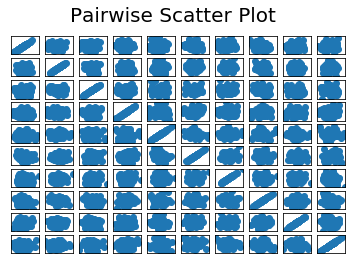

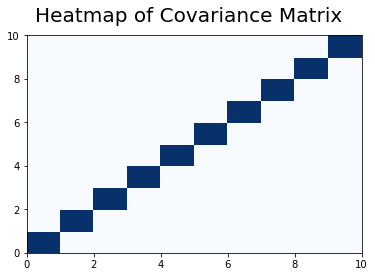

In [3]:
n_data_points = 100
n_features = 10

# try changing this to the correlated data!
# For the correlated what happens when you set phi = 0?
X, covar = make_independent_data(n_features, n_data_points)

fig = plt.figure()

# tracking which sub plot we use
count = 0

for ii in range(n_features):
    for jj in range(n_features):
        count += 1 # sub-plot location increments
        ax = plt.subplot(n_features, n_features, count)
        plt.setp(ax, xticks=(), yticks=())    
        plt.scatter(X[:, ii], X[:, jj])  
        ax.set_xlim([np.min(X), np.max(X)])
        ax.set_ylim([np.min(X), np.max(X)])
        
fig.suptitle('Pairwise Scatter Plot', fontsize=20)
        
fig = plt.figure()
heatmap = plt.pcolor(covar, cmap=mp.cm.Blues)
fig.suptitle('Heatmap of Covariance Matrix', fontsize=20)

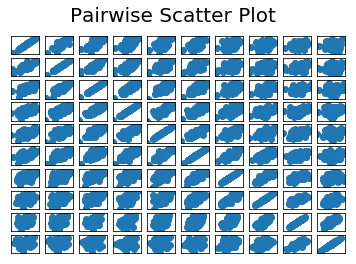

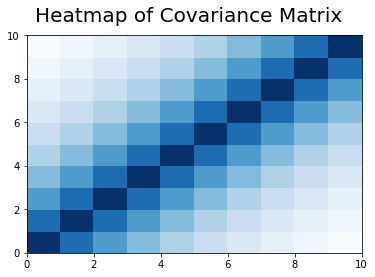

In [9]:
n_data_points = 100
n_features = 10

# try changing this to the correlated data!
# For the correlated what happens when you set phi = 0?
X, covar = make_correlated_data(n_features, n_data_points, phi = .8)
# 0 is same as above with only correlation between number and self
# .75 is increased correlation and blurring of heat map

fig = plt.figure()

# tracking which sub plot we use
count = 0

for ii in range(n_features):
    for jj in range(n_features):
        count += 1 # sub-plot location increments
        ax = plt.subplot(n_features, n_features, count)
        plt.setp(ax, xticks=(), yticks=())    
        plt.scatter(X[:, ii], X[:, jj])  
        ax.set_xlim([np.min(X), np.max(X)])
        ax.set_ylim([np.min(X), np.max(X)])
        
fig.suptitle('Pairwise Scatter Plot', fontsize=20)
        
fig = plt.figure()
heatmap = plt.pcolor(covar, cmap=mp.cm.Blues)
fig.suptitle('Heatmap of Covariance Matrix', fontsize=20)

Now, let's extend our simulation to a regression problem. Here, we'll create a function which does the following.

1. Using our data generation functions above, create some features. We'll create a data matrix which has 'n_data_points' rows [called either data points; examples; observations] and 'n_feature + n_noise_features' columns [called either features; independent variables; etc.]. We can allow for correlation between the features with the phi parameter, as above.
2. We then generate a relationship between X and Y: beta. This will be a vector of length 'n_feature + n_noise_features'. The first n_feature entries will be equal to 'signal_strength', the remained will be equal to zero.
1. The outcome Y, will be the result of adding X * beta + noise; where X is from step 1, beta is from step 2, and the noise vector is a vector of length 'n_data_points' filled with random normal draws.

In [10]:
def create_data_set(n_train_points,
                    n_test_points,
                    n_features, 
                    n_noise_features, 
                    phi, 
                    signal_strength):
    """Create a complete data set for a regression problem

    Arguments:
    n_data_points: integer number of data points
    n_features: integer number of features that have nonzero coefficients
    n_noise_features: integer number of features that have zero coefficients
    phi: correlation parameter between features; decays are differnce in index increases
    signal_strength: mean value of nonzero coefficients
    n_train_points: number of data points to place in training set from the total n_data_points
    """
    
    # create true set of coefficients
    #true_linear_model = np.concatenate((np.random.normal(size=n_features, scale=0.5) + signal_strength, 
    #                                    np.zeros(n_noise_features)))
    
    n_data_points = n_train_points + n_test_points
    
    true_linear_model = np.concatenate((np.zeros(n_features) + signal_strength,
                                        np.zeros(n_noise_features)))

    # make things the right shape
    true_linear_model = np.reshape(np.array(true_linear_model), 
                                   newshape=(n_features + n_noise_features, 1))

    # make the data now using make_correlated_data
    X, _ = make_correlated_data(n_features + n_noise_features, n_data_points, phi)

    # use the features and the coefficients to make the data
    Y_signal = np.dot(X, true_linear_model) # Y = X * beta
    Y_noise = np.reshape(np.random.normal(size=n_data_points, scale=1), 
                         newshape=(n_data_points, 1))
    Y = np.add(Y_signal, Y_noise)

    Y = Y.flatten()

    # train, test split
    train_data, train_labels = X[:n_train_points], Y[:n_train_points]
    test_data, test_labels = X[n_train_points:], Y[n_train_points:]
    
    return train_data, train_labels, test_data, test_labels, true_linear_model

Try generating a data set for regression using the above. Compute a prediction error on the test data, what do you find? Try with different phi parameter values, and differing amount of noise variables.

Is there a relationship between phi and the test error? Why?- increased PHI leads no change in test error?

Try adding noise variables, what impact does that have?- small increase in noise reduces error but larger amounts of noise increase error

In [54]:
np.random.seed(100)

#phi =0, noise = 0, error= 1.58
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(50, 50, 5, 0, 0, 2)

lm = LinearRegression()
lm.fit(train_data, train_labels)
accuracy = lm.score(test_data, test_labels)

lm_test_mse = ((lm.predict(test_data[:,]) - test_labels) ** 2).mean()
print("accuracy: ", accuracy)
print("error: ", lm_test_mse)


### SOL'N?

accuracy:  0.939928083759
error:  1.58071557911


In [56]:
np.random.seed(100)
#phi = .7, noise = 0, error = 1.58
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(50, 50, 5, 0, 0.7, 2)

lm = LinearRegression()
lm.fit(train_data, train_labels)
accuracy = lm.score(test_data, test_labels)
lm_test_mse = ((lm.predict(test_data[:,]) - test_labels) ** 2).mean()
print("accuracy: ", accuracy)
print("error: ", lm_test_mse)



accuracy:  0.9611712506
error:  1.58071557911


In [59]:
np.random.seed(100)
# phi = .5 and 0 noise features, error 1.58
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(50, 50, 5, 0, 0.5, 2)

lm = LinearRegression()
lm.fit(train_data, train_labels)
accuracy = lm.score(test_data, test_labels)
lm_test_mse = ((lm.predict(test_data[:,]) - test_labels) ** 2).mean()
print("accuracy: ", accuracy)
print("error: ", lm_test_mse)


accuracy:  0.946611756327
error:  1.58071557911


In [63]:
np.random.seed(100)
# phi = .5 and 2 noise features, error .917
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(50, 50, 5, 2, 0.5, 2)

lm = LinearRegression()
lm.fit(train_data, train_labels)
accuracy = lm.score(test_data, test_labels)
lm_test_mse = ((lm.predict(test_data[:,]) - test_labels) ** 2).mean()
print("accuracy: ", accuracy)
print("error: ", lm_test_mse)

accuracy:  0.984067446936
error:  0.917258242527


In [65]:
np.random.seed(100)
# phi = .5 and 10 noise features, error = 1.40
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(50, 50, 5, 10, 0.5, 2)

lm = LinearRegression()
lm.fit(train_data, train_labels)
accuracy = lm.score(test_data, test_labels)
lm_test_mse = ((lm.predict(test_data[:,]) - test_labels) ** 2).mean()
print("accuracy: ", accuracy)
print("error: ", lm_test_mse)



accuracy:  0.960241813964
error:  1.40147190307


In [67]:
np.random.seed(100)
# phi = .99 and 0 noise features, error =1.58
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(50, 50, 5, 0, .99, 2)

lm = LinearRegression()
lm.fit(train_data, train_labels)
accuracy = lm.score(test_data, test_labels)
lm_test_mse = ((lm.predict(test_data[:,]) - test_labels) ** 2).mean()
print("accuracy: ", accuracy)
print("error: ", lm_test_mse)


accuracy:  0.975647385419
error:  1.58071557911


In [76]:
np.random.seed(100)
# phi = .99 and 2 noise features, error= .917 
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(50, 50, 5, 2, .99, 2)

lm = LinearRegression()
lm.fit(train_data, train_labels)
accuracy = lm.score(test_data, test_labels)
lm_test_mse = ((lm.predict(test_data[:]) - test_labels) ** 2).mean()
print("accuracy: ", accuracy)
print("error: ", lm_test_mse)




accuracy:  0.991901553649
error:  0.917258242527


In [77]:
np.random.seed(100)
# phi = .99 and 10 noise features, error= 1.40
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(50, 50, 5, 10, .99, 2)

lm = LinearRegression()
lm.fit(train_data, train_labels)
accuracy = lm.score(test_data, test_labels)
lm_test_mse = ((lm.predict(test_data[:,]) - test_labels) ** 2).mean()
print("accuracy: ", accuracy)
print("error: ", lm_test_mse)

accuracy:  0.986586217844
error:  1.40147190307


When we add noise variables, we have some extra variables that really do not help in the true model; they also interfere with good predictions. Here's a comparison of what linear regression estimates versus what the true model has.

What is the impact of phi here?

Try adding more noise variables: what do you see?

Linear model test MSE:  1.0250182158


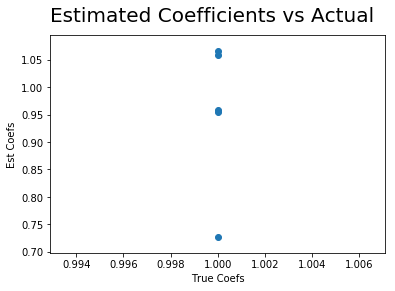

In [40]:
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(100, 50, 5, 0, 0, 1)

lm = LinearRegression()
lm.fit(train_data, train_labels)

lm_coef = lm.coef_

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

print("Linear model test MSE: ", lm_test_mse)

# plot estimated coefficients versus the actual coefficients
fig = plt.figure()
plt.scatter(true_linear_model, lm_coef)
fig.suptitle('Estimated Coefficients vs Actual', fontsize=20)
plt.xlabel('True Coefs')
plt.ylabel('Est Coefs') 

Linear model test MSE:  0.825533040948


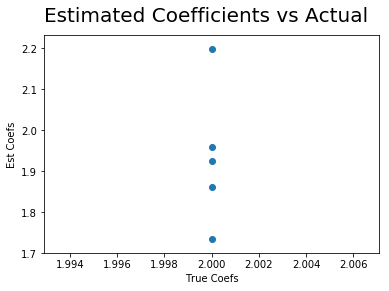

In [41]:
#phi =0
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(50, 50, 5, 0, 0, 2)

lm = LinearRegression()
lm.fit(train_data, train_labels)

lm_coef = lm.coef_

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

print("Linear model test MSE: ", lm_test_mse)

# plot estimated coefficients versus the actual coefficients
fig = plt.figure()
plt.scatter(true_linear_model, lm_coef)
fig.suptitle('Estimated Coefficients vs Actual', fontsize=20)
plt.xlabel('True Coefs')
plt.ylabel('Est Coefs') 

Linear model test MSE:  1.25350034336


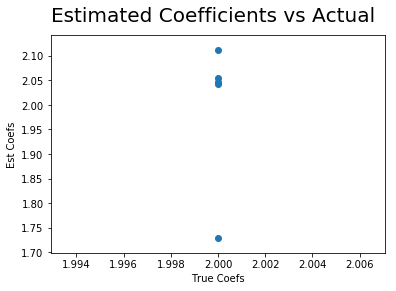

In [42]:
#phi = .7
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(50, 50, 5, 0, 0.7, 2)

lm = LinearRegression()
lm.fit(train_data, train_labels)

lm_coef = lm.coef_

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

print("Linear model test MSE: ", lm_test_mse)

# plot estimated coefficients versus the actual coefficients
fig = plt.figure()
plt.scatter(true_linear_model, lm_coef)
fig.suptitle('Estimated Coefficients vs Actual', fontsize=20)
plt.xlabel('True Coefs')
plt.ylabel('Est Coefs') 

Linear model test MSE:  0.917258242527


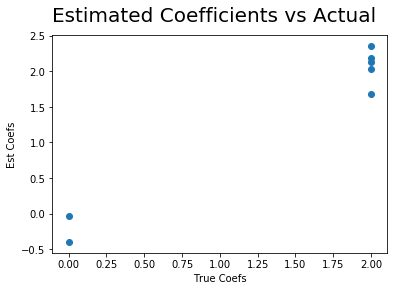

In [43]:
np.random.seed(100)
# phi = .5 and 2 noise features
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(50, 50, 5, 2, 0.5, 2)
lm = LinearRegression()
lm.fit(train_data, train_labels)

lm_coef = lm.coef_

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

print("Linear model test MSE: ", lm_test_mse)

# plot estimated coefficients versus the actual coefficients
fig = plt.figure()
plt.scatter(true_linear_model, lm_coef)
fig.suptitle('Estimated Coefficients vs Actual', fontsize=20)
plt.xlabel('True Coefs')
plt.ylabel('Est Coefs') 

Linear model test MSE:  1.40147190307


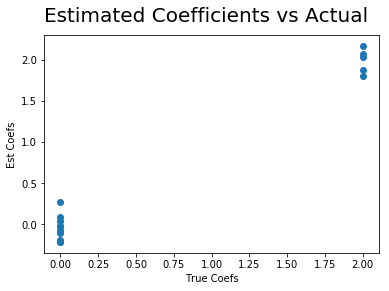

In [44]:
np.random.seed(100)
# phi = .5 and 10 noise features
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(50, 50, 5, 10, 0.5, 2)

lm = LinearRegression()
lm.fit(train_data, train_labels)

lm_coef = lm.coef_

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

print("Linear model test MSE: ", lm_test_mse)

# plot estimated coefficients versus the actual coefficients
fig = plt.figure()
plt.scatter(true_linear_model, lm_coef)
fig.suptitle('Estimated Coefficients vs Actual', fontsize=20)
plt.xlabel('True Coefs')
plt.ylabel('Est Coefs') 

Linear model test MSE:  1.40147190307


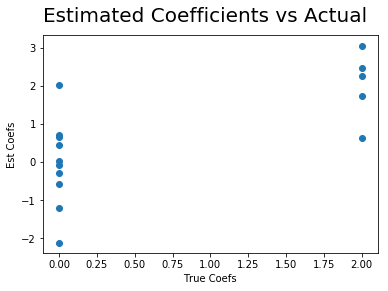

In [45]:
np.random.seed(100)
# phi = .99 and 10 noise features
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(50, 50, 5, 10, .99, 2)

lm = LinearRegression()
lm.fit(train_data, train_labels)

lm_coef = lm.coef_

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

print("Linear model test MSE: ", lm_test_mse)

# plot estimated coefficients versus the actual coefficients
fig = plt.figure()
plt.scatter(true_linear_model, lm_coef)
fig.suptitle('Estimated Coefficients vs Actual', fontsize=20)
plt.xlabel('True Coefs')
plt.ylabel('Est Coefs') 

Linear model test MSE:  0.917258242527


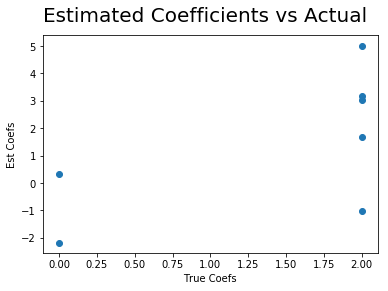

In [46]:
np.random.seed(100)
# phi = .99 and 2 noise features
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(50, 50, 5, 2, .99, 2)

lm = LinearRegression()
lm.fit(train_data, train_labels)

lm_coef = lm.coef_

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

print("Linear model test MSE: ", lm_test_mse)

# plot estimated coefficients versus the actual coefficients
fig = plt.figure()
plt.scatter(true_linear_model, lm_coef)
fig.suptitle('Estimated Coefficients vs Actual', fontsize=20)
plt.xlabel('True Coefs')
plt.ylabel('Est Coefs') 

One thing that is going wrong in the above when we have noise variables: we are assigning non-zero vlaues to coefficients with truly zero coefficients.

Now, we can try implementing stepwise regression, which is a simple greedy algorithm for selecting a sub model. Here's a plan:

1. Start with an empty model (no variables used)
2. For each variable not included:
a. Fit a model with that variable included, record the prediction performance
3. Add the variable that did the best in 2a to the set
4. Repeat until all variables are in the model

How could we choose how to stop this loop (when have we added 'enough' variables)?

('Sequence of test set errors:', [10.631799275464022, 2.5736650950909925, 1.7984120229326099, 1.2543245988362337, 1.230978101450231, 1.1989578750985905, 1.2086893987900504, 1.175409267921675, 1.345685399522818])


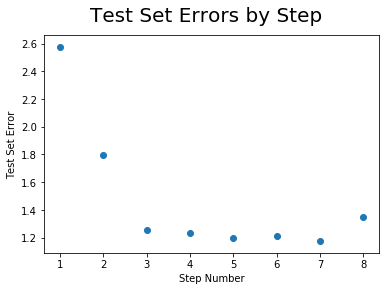

In [8]:
np.random.seed(100) # "simulation"

# generate the data set
train_data, train_labels, test_data, test_labels, true_linear_model = create_data_set(80, 60, 3, 5, 0.75, 1)

# set of variables 'in' the model, and 'out' of the model
# we begin with all variables out of the model, and no variables in the model
invar = []
outvar = range(train_data.shape[1])

# begin with the null model; store the MSE
intercept = test_labels.mean()
error = ((test_labels - intercept) ** 2).mean()
errorseq = [error]

# stepwise regression loop
for jj in range(train_data.shape[1]):
    varscores = []
    
    # loop over all variables in the 'out' set
    for idx, ovar in enumerate(outvar):
        # temporarily add the variable the the in set
        vartemp = invar[:]
        vartemp.append(ovar)
        vartemp = np.array(vartemp)
        
        # check the MSE on the test set
        lm = LinearRegression()
        lm.fit(train_data[:, vartemp], train_labels)
        lm_test_mse = ((lm.predict(test_data[:, vartemp]) - test_labels) ** 2).mean()
        varscores.append(lm_test_mse)
    
    # take the variable with the smallest test set MSE
    argmin_selection = np.argmin(np.array(varscores))
    errorseq.append(varscores[argmin_selection])
    invar.append(outvar.pop(argmin_selection))

# results; diagnostics
print("Sequence of test set errors:", errorseq)

fig = plt.figure()
plt.scatter(range(len(errorseq))[1:], errorseq[1:])
fig.suptitle('Test Set Errors by Step', fontsize=20)
plt.xlabel('Step Number')
plt.ylabel('Test Set Error') 
 
# SOL'N ?



Is this the only way to do variable selection? Turns out there is a way to cast this entire task as a single optimization problem, called *regularization*.

**Regularization in general**

Typical learning objectives simply optimizes the fit. It looks like (here beta are some parameters that define the model, say the coefficients in linear regression):

Objective(beta) = fit(beta)

And we do:

beta-hat = argmin(Objective(beta))

So, we choose the beta that minimizes the objective, that is, provides the best fit to the training data.

Regularization simply tweaks this by:

RegularizedObjective(beta) = fit(beta) + alpha * penalty(beta)

And, as above:

regularized-beta-hat = argmin(RegularizedObjective(beta))

So, what is the penalty? It is a way to define the complexity of beta. We'll see how complexity is defined below. But, in general, as the fit gets better, the complexity becomes higher, and so the objective nicely formalizes this tradeoff. Alpha is a constant (we'll have to pick it) that defines the strength of this tradeoff.

We can define complexity in a couple of ways: (1) large values of coefficients are one indication; (2) using many dimensions (non-zero coefficients) are another indication. Regularization can caputre both.

## L2 regularization: shrinkage

Let's explore the first type of regularization, L2 regularization. It takes the form:

Objective(beta) = fit(beta) + alpha * sum_j(beta_j^2)

Some useful docs for the following:

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html


In [78]:
lm = LinearRegression()
lm.fit(train_data, train_labels)

lm_test_mse = ((lm.predict(test_data) - test_labels) ** 2).mean()

rm = Ridge(alpha=1, normalize=False)
rm.fit(train_data, train_labels)

rm_test_mse = ((rm.predict(test_data) - test_labels) ** 2).mean()

print("Linear model test MSE:     ", lm_test_mse)
print("Ridge regression test MSE: ", rm_test_mse)
print("Linear regression does worse on the test set: ", lm_test_mse > rm_test_mse)

Linear model test MSE:      1.40147190307
Ridge regression test MSE:  1.18998060731
Linear regression does worse on the test set:  True


Now, let's see what happens to the coefficients as alpha changes. Here's an investigation for a single coefficient, for a single alpha value.

Plot the relationship between alpha and the coefficient value. this is essentially a *regularization path plot*, for more examples of this:

http://fa.bianp.net/blog/2011/ridge-regression-path/

In [80]:
alpha = 0.1
coef_idx = 1

lm = LinearRegression()
lm.fit(train_data, train_labels)

rm = Ridge(alpha=alpha, normalize=True)
rm.fit(train_data, train_labels)

lm_coef = lm.coef_[coef_idx]
rm_coef = rm.coef_[coef_idx]

print("At alpha = ", alpha, " LR estimtes ", lm_coef, " Ridge estimates ", rm_coef)

# SOL'N


At alpha =  0.1  LR estimtes  3.05019408289  Ridge estimates  1.74251021471


We also said that ridge regression reduces the variance of the estimator in exchange for more bais.

Based on the above, where can we see the bias in the coefficient estimate?

Plot the predictions versus the actual, for different values of alpha, can you see the variance decrease?

(-23.012622580187752, 23.477569044187906)

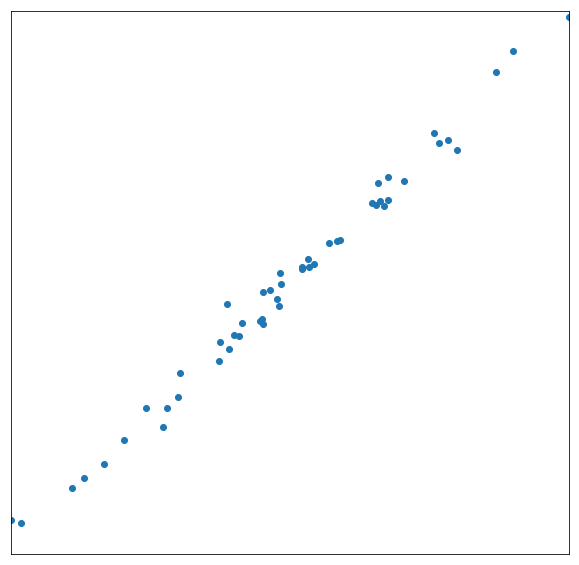

In [82]:
alpha = 0.1
coef_idx = 1

lm = LinearRegression()
lm.fit(train_data, train_labels)

rm = Ridge(alpha=alpha, normalize=True)
rm.fit(train_data, train_labels)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
plt.setp(ax, xticks=(), yticks=())    
plt.scatter(test_labels, rm.predict(test_data))
ax.set_xlim([np.min(test_labels), np.max(test_labels)])
ax.set_ylim([np.min(test_labels), np.max(test_labels)])

# SOL'N
